# Проект: классификация

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код

In [5]:
df = pd.read_csv('../data/bank_fin.csv', sep = ';')

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [8]:
df.describe()

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [9]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [10]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код

In [11]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [12]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [13]:
df['balance'] = df['balance'].apply(lambda item: str(item).replace(" $", "").replace(" ", "").replace(",", ".").strip()).astype(float)

In [14]:
df['balance'].mean()

1529.1290293615875

### Задание 4

In [15]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

In [16]:
df['balance'] = df['balance'].fillna(df['balance'].median())

In [17]:
df['balance'].mean()

1526.9360329690019

### Задание 5

In [18]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код

In [19]:
df['job'] = df['job'].apply(lambda item: df['job'].mode().tolist()[0] if item == 'unknown' else item)
df['education'] = df['education'].apply(lambda item: df['education'].mode().tolist()[0] if item == 'unknown' else item)

In [20]:
most_popular_job = df["job"].value_counts()[:1].index.tolist()[0]
most_popular_education = df["education"].value_counts()[:1].index.tolist()[0]

In [21]:
job_education = df[(df["job"] == most_popular_job) & (df["education"] == most_popular_education)]

In [22]:
job_education["balance"].mean()

1598.8829787234042

### Задание 6

In [23]:
# удалите все выбросы для признака balance
# ваш код

In [24]:
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)
IQR = Q3 - Q1

low_border = Q1 - 1.5 * IQR
high_border = Q3 + 1.5 * IQR

print(f"low border - {low_border}")
print(f"high border - {high_border}")

low border - -2241.0
high border - 4063.0


In [25]:
df = df[(df['balance'] >= low_border) & (df['balance'] <= high_border)]

In [26]:
df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

In [27]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код

<AxesSubplot:>

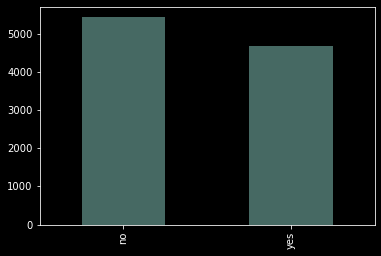

In [28]:
df["deposit"].value_counts().plot.bar(x="deposit", y="count", alpha=0.5)

<AxesSubplot:xlabel='deposit', ylabel='count'>

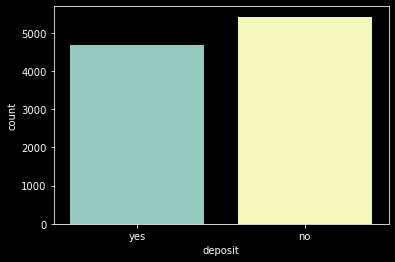

In [29]:
sns.countplot(x="deposit", data=df)

In [30]:
df["deposit"].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задание 2

In [31]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

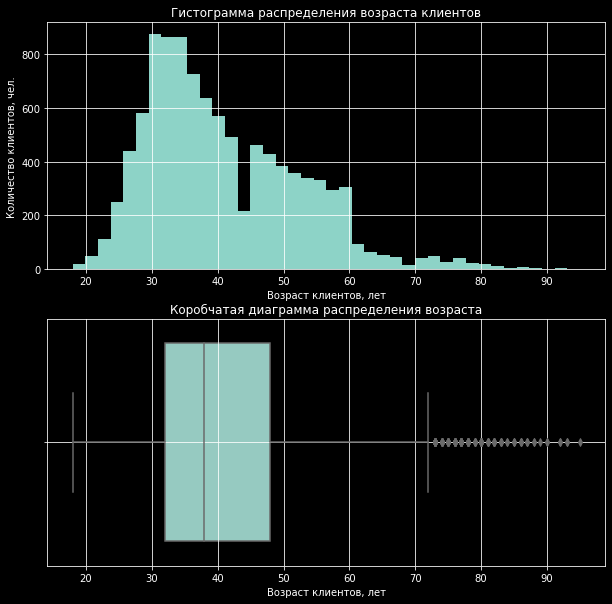

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes[0].hist(x=df['age'], bins=40)
axes[0].set_xlabel('Возраст клиентов, лет')
axes[0].set_ylabel('Количество клиентов, чел.')
axes[0].set_title('Гистограмма распределения возраста клиентов')
axes[0].grid()

boxplot=sns.boxplot( data=df,x='age')
boxplot.set_title('Коробчатая диаграмма распределения возраста')
boxplot.set_xlabel('Возраст клиентов, лет')
boxplot.grid()

In [33]:
print(f"Максимальный возраст клиента - {df['age'].max()}")

Максимальный возраст клиента - 95


### Задание 3

In [34]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

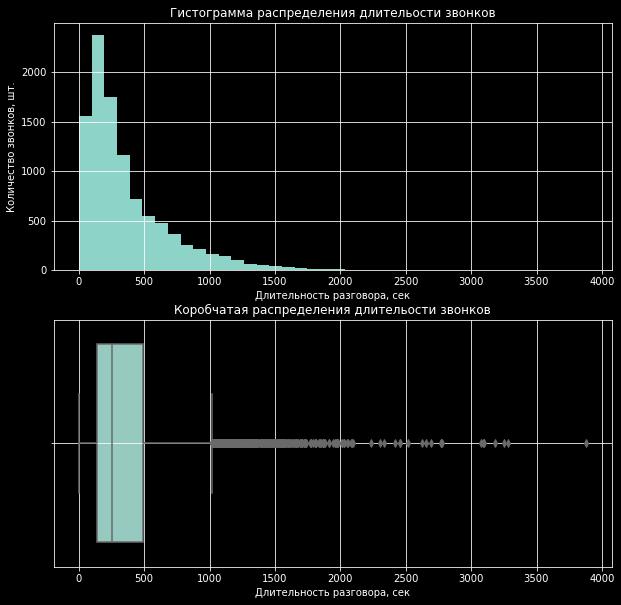

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axes[0].hist(x=df['duration'], bins=40)
axes[0].set_xlabel('Длительность разговора, сек')
axes[0].set_ylabel('Количество звонков, шт.')
axes[0].set_title('Гистограмма распределения длительости звонков')
axes[0].grid()

boxplot=sns.boxplot( data=df,x='duration')
boxplot.set_title('Коробчатая распределения длительости звонков')
boxplot.set_xlabel('Длительность разговора, сек')
boxplot.grid()

In [36]:
print(f"минимальная длительность разговора - {df['duration'].min()} сек")

минимальная длительность разговора - 2 сек


Text(0.5, 1.0, 'Сферы занятости клиентов банка')

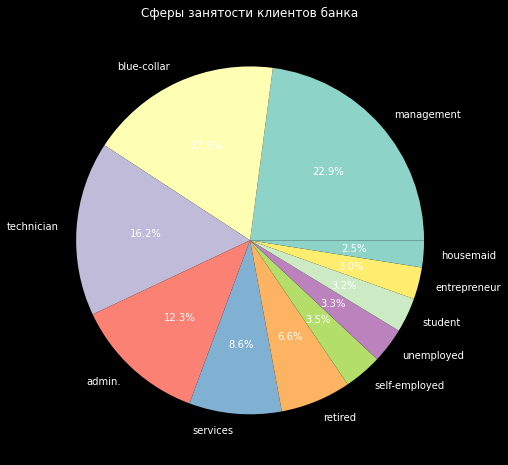

In [37]:
fig, axes = plt.subplots(figsize=(8, 8))
axes.pie(
    df['job'].value_counts(),
    labels=df['job'].value_counts().index,
    autopct='%.1f%%'
)
axes.set_title('Сферы занятости клиентов банка')

In [38]:
df['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

<AxesSubplot:xlabel='month', ylabel='count'>

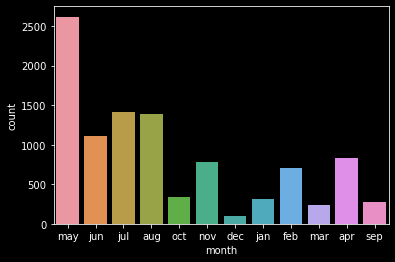

In [39]:
sns.countplot(x="month", data=df)

<AxesSubplot:xlabel='marital', ylabel='count'>

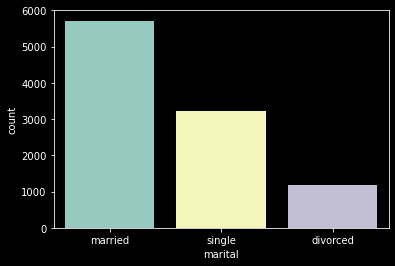

In [40]:
sns.countplot(x="marital", data=df)

<AxesSubplot:xlabel='education', ylabel='count'>

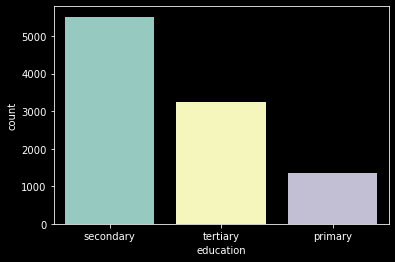

In [41]:
sns.countplot(x="education", data=df)

### Задание 4

In [42]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

In [43]:
df.groupby("poutcome").count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,deposit
poutcome,,,,,,,,,,,,,,,,
failure,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109
other,481,481,481,481,481,481,481,481,481,481,481,481,481,481,481,481
success,945,945,945,945,945,945,945,945,945,945,945,945,945,945,945,945
unknown,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570,7570


### Задание 5

In [44]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

In [45]:
df["index"] = df.index

In [46]:
pivot = df.pivot_table(
    'index',
    index='poutcome',
    columns='month',
    aggfunc='count'
)

pivot = pivot.drop("unknown", axis=0)

for m in pivot.columns:
    pivot[m] = np.round(pivot[m]/pivot[m].sum(), 3)
    
pivot

month,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
poutcome,,,,,,,,,,,,
failure,0.515,0.327,0.216,0.462,0.348,0.318,0.300,0.295,0.593,0.527,0.360,0.274
other,0.220,0.140,0.235,0.200,0.321,0.197,0.175,0.227,0.200,0.152,0.116,0.185
success,0.265,0.533,0.549,0.338,0.330,0.485,0.525,0.477,0.207,0.322,0.523,0.542


### Задание 6

In [47]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

In [48]:
def get_age_interval(val: int) -> str:
    if val < 30:
        return '<30'
    elif val >= 30 and val < 40:
        return '30-40'
    elif val >= 40 and val < 50:
        return '40-50'
    elif val >= 50 and val < 60:
        return '50-60'
    else:
        return '60+'

In [49]:
df["age_interval"]= df['age'].apply(get_age_interval)

In [50]:
df["age_interval"].value_counts()

30-40    3961
40-50    2382
50-60    1654
<30      1455
60+       653
Name: age_interval, dtype: int64

In [51]:
pivot = df.pivot_table(
    'index',
    index='age_interval',
    columns='deposit',
    aggfunc='count'
)

pivot

deposit,no,yes
age_interval,,
30-40,2245,1716
40-50,1444,938
50-60,984,670
60+,157,496
<30,594,861


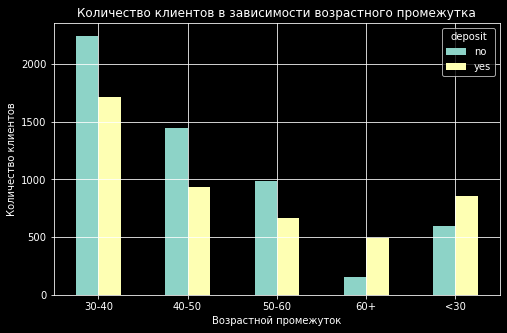

In [52]:
fig, axes = plt.subplots(figsize=(8, 5))
pivot.plot(kind='bar', ax=axes)
axes.set_title('Количество клиентов в зависимости возрастного промежутка')
axes.set_xlabel('Возрастной промежуток')
axes.set_ylabel('Количество клиентов')
axes.tick_params(axis='x', labelrotation = 0)
axes.grid()

### Задание 7

In [53]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [54]:
pivot_marital = df.pivot_table(
    'index',
    index='marital',
    columns='deposit',
    aggfunc='count'
)
pivot_marital

deposit,no,yes
marital,,
divorced,624,553
married,3303,2412
single,1497,1716


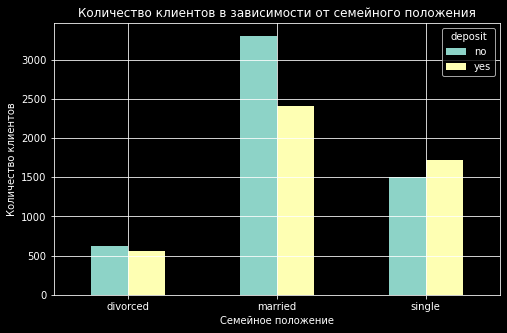

In [55]:
fig, axes = plt.subplots(figsize=(8, 5))
pivot_marital.plot(kind='bar', ax=axes)
axes.set_title('Количество клиентов в зависимости от семейного положения')
axes.set_xlabel('Семейное положение')
axes.set_ylabel('Количество клиентов')
axes.tick_params(axis='x', labelrotation = 0)
axes.grid()

In [56]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [57]:
pivot_education = df.pivot_table(
    'index',
    index='education',
    columns='deposit',
    aggfunc='count'
)
pivot_education

deposit,no,yes
education,,
primary,832,517
secondary,3066,2451
tertiary,1526,1713


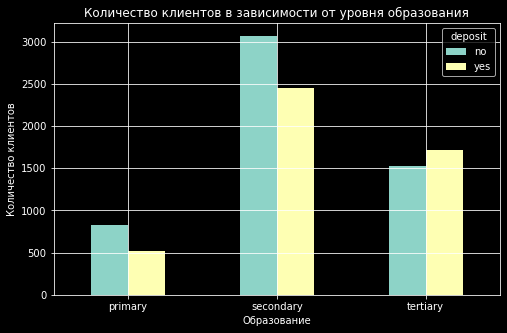

In [58]:
fig, axes = plt.subplots(figsize=(8, 5))
pivot_education.plot(kind='bar', ax=axes)
axes.set_title('Количество клиентов в зависимости от уровня образования')
axes.set_xlabel('Образование')
axes.set_ylabel('Количество клиентов')
axes.tick_params(axis='x', labelrotation = 0)
axes.grid()

In [59]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

In [60]:
pivot_job = df.pivot_table(
    'index',
    index='job',
    columns='deposit',
    aggfunc='count'
)
pivot_job

deposit,no,yes
job,,
admin.,672,574
blue-collar,1155,652
entrepreneur,189,111
housemaid,153,99
management,1180,1135
retired,231,432
self-employed,197,161
services,523,345
student,81,245


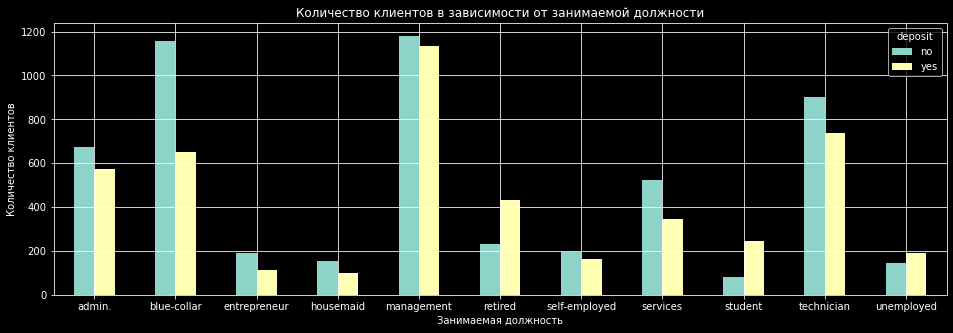

In [61]:
fig, axes = plt.subplots(figsize=(16, 5))
pivot_job.plot(kind='bar', ax=axes)
axes.set_title('Количество клиентов в зависимости от занимаемой должности')
axes.set_xlabel('Занимаемая должность')
axes.set_ylabel('Количество клиентов')
axes.tick_params(axis='x', labelrotation = 0)
axes.grid()

### Задание 8

In [62]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

In [63]:
yes_table = df[df["deposit"] == "yes"]
no_table = df[df["deposit"] == "no"]

In [64]:
yes_pivot_job_marital = yes_table.pivot_table(
    'index',
    index='education',
    columns='marital',
    aggfunc='count'
)
yes_pivot_job_marital

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [65]:
no_pivot_job_marital = no_table.pivot_table(
    'index',
    index='education',
    columns='marital',
    aggfunc='count'
)
no_pivot_job_marital

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


Text(0.5, 1.0, 'Не открыли депозит')

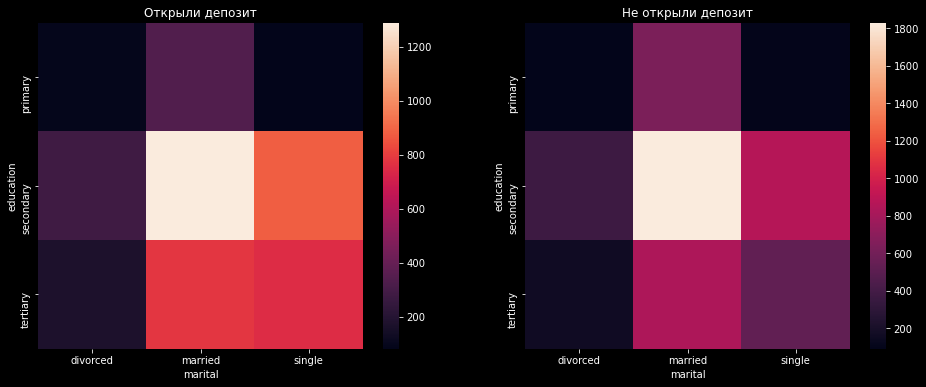

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
heat_map_yes = sns.heatmap(yes_pivot_job_marital, ax=axes[0])
heat_map_yes.set_title("Открыли депозит")
heat_map_no = sns.heatmap(no_pivot_job_marital, ax=axes[1])
heat_map_no.set_title("Не открыли депозит")

In [67]:
df = df.drop("index", axis=1)

## Часть 3: преобразование данных

### Задание 1

In [68]:
# преобразуйте уровни образования

In [69]:
le = LabelEncoder()

le.fit(df["education"])
df["education"] = le.transform(df["education"])

In [70]:
df["education"].sum()

11995

In [71]:
le = LabelEncoder()

le.fit(df["deposit"])
df["deposit"] = le.transform(df["deposit"])

In [72]:
df["deposit"].std()

0.4986712532451993

### Задание 2

In [73]:
# преобразуйте бинарные переменные в представление из нулей и единиц

In [74]:
df["default"] = df["default"].apply(lambda x: 1 if x == 'yes' else 0)
df["housing"] = df["housing"].apply(lambda x: 1 if x == 'yes' else 0)
df["loan"] = df["loan"].apply(lambda x: 1 if x == 'yes' else 0)

In [75]:
df["default"].mean() + df["housing"].mean() + df["loan"].mean()

0.6354280059376547

### Задание 3

In [76]:
# создайте дамми-переменные

In [77]:
dammies_df = pd.get_dummies(df[["job", "marital", "contact", "month", "poutcome", "age_interval"]])
df = pd.concat([df, dammies_df], axis=1)
df = df.drop(["job", "marital", "contact", "month", "poutcome", "age_interval"], axis=1)

In [78]:
df.shape

(10105, 50)

In [79]:
df.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'age_interval_30-40', 'age_interval_40-50',
       'age_interval_50-60', 'age_interval_60+', 'age_interval_<30'],
      dtype='object')

### Задание 4

In [80]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

In [81]:
columns = df.columns.to_list()

In [82]:
corr_matrix = df.corr()
print(corr_matrix['deposit']["duration"])
print(corr_matrix['deposit']["poutcome_success"])
print(corr_matrix['deposit']["contact_cellular"])

0.45781769360301033
0.2884909754116557
0.22394444543236658


<AxesSubplot:>

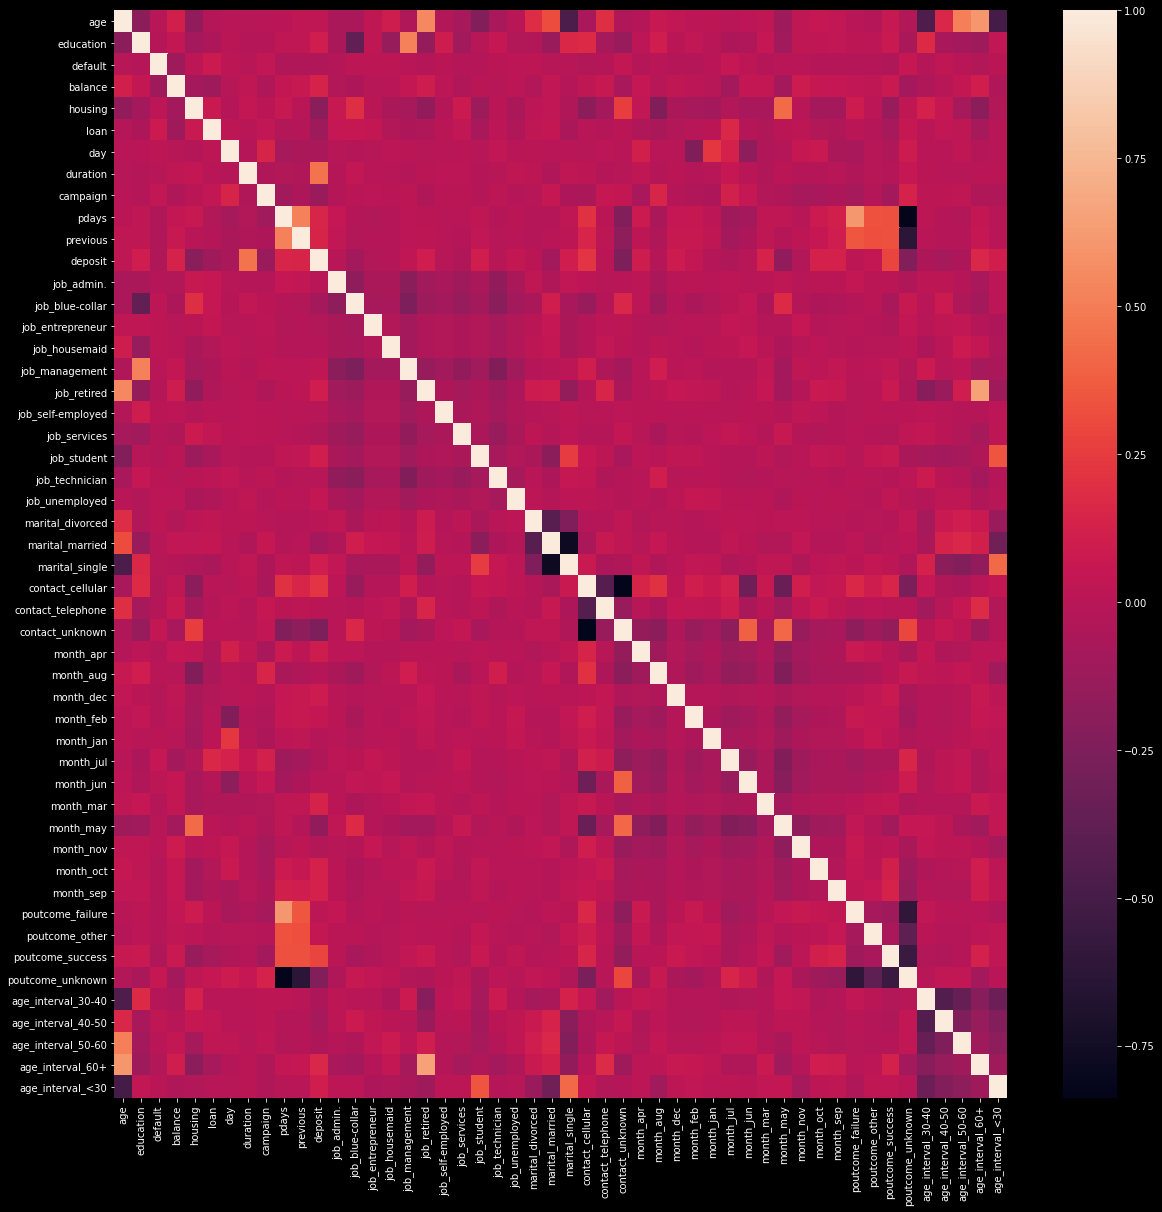

In [83]:
fig, axes = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, ax=axes)

### Задание 5

In [84]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [85]:
# рассчитайте необходимые показатели

In [86]:
y_test.shape

(3335,)

In [87]:
y_test.mean()

0.46326836581709147

### Задание 6

In [88]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

In [89]:
X_train = X_train.select_dtypes(include=['float64', 'int64', 'uint8'])
X_test = X_test.select_dtypes(include=['float64', 'int64', 'uint8'])

In [90]:
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
cols = selector.get_support(indices=True)

In [91]:
for i, j in enumerate(X_train.columns):
    if i in cols and "month" in j:
        print(j)

month_mar
month_may
month_oct
month_sep


### Задание 7

In [92]:
# нормализуйте данные с помощью minmaxsxaler

In [93]:

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_scaled = min_max_scaler.transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [94]:
X_test_scaled[0].mean()

0.1586246050273035

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [95]:
# обучите логистическую регрессию и рассчитайте метрики качества

In [96]:
model_lr = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag')
model_lr.fit(X_train_scaled, y_train)
y_lt_pred = model_lr.predict(X_test_scaled)

In [97]:
metrics.accuracy_score(y_pred=y_lt_pred, y_true=y_test)

0.8179910044977511

### Задание 2

In [98]:
# обучите решающие деревья, настройте максимальную глубину

In [99]:
max_depth_list = []
accuracy_test_list = []
accuracy_train_list = []

for i in range(2, 30):
    model_dtc = tree.DecisionTreeClassifier(random_state=42, max_depth=i)
    model_dtc.fit(X_train_scaled, y_train)
    y_pred_test = model_dtc.predict(X_test_scaled)
    accuracy_test_list.append(metrics.accuracy_score(y_test, y_pred_test))
    y_pred_train = model_dtc.predict(X_train_scaled)
    accuracy_train_list.append(metrics.accuracy_score(y_train, y_pred_train))
    max_depth_list.append(i)

In [100]:
data = {"Max depth": max_depth_list, "Accuracy test": accuracy_test_list, "Accuracy train": accuracy_train_list}

<AxesSubplot:xlabel='Max depth', ylabel='Accuracy test'>

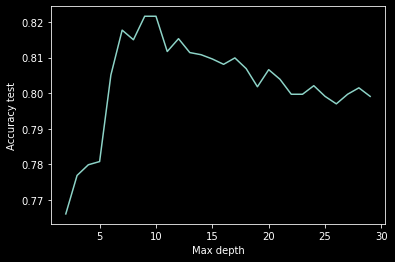

In [101]:
sns.lineplot(x="Max depth", y="Accuracy test", data=data)

In [102]:
max(accuracy_test_list)

0.8215892053973014

In [103]:
ind = accuracy_test_list.index(max(accuracy_test_list))
max_depth_list[ind]

9

In [104]:
model_dtc = tree.DecisionTreeClassifier(random_state=42, max_depth=i)

### Задание 3

In [105]:
# подберите оптимальные параметры с помощью gridsearch

In [106]:
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
    }

In [108]:
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
) 

In [109]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]})

In [111]:
y_grid_pred = grid_search.predict(X_test_scaled)

In [112]:
metrics.f1_score(y_test, y_grid_pred)

0.8105395232120451

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

In [113]:
model_rft = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    min_samples_leaf=5, 
    max_depth=10, 
    random_state=42
    )

In [114]:
model_rft.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [115]:
y_dtc_pred = model_rft.predict(X_test_scaled)

In [116]:
print(f"Accuracy: {metrics.accuracy_score(y_test, y_dtc_pred)}")
print(f"Recall: {metrics.recall_score(y_test, y_dtc_pred)}")

Accuracy: 0.8377811094452774
Recall: 0.8517799352750809


### Задание 2

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

In [117]:
model_gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)

In [118]:
model_gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [119]:
y_gb_pred = model_gb.predict(X_test_scaled)

In [120]:
print(f"F1: {metrics.f1_score(y_test, y_gb_pred)}")

F1: 0.8502994011976047


### Задание3

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

In [125]:
estimators = [
    ('dtc', tree.DecisionTreeClassifier(random_state=42, max_depth=6)),
    ('lr',  linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='sag'))
]

In [126]:
reg = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
    )
)

In [127]:
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dtc',
                                DecisionTreeClassifier(max_depth=6,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag'))],
                   final_estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                              max_depth=5,
                                                              min_samples_leaf=5,
                                                              n_estimators=300,
                                                              random_state=42))

In [128]:
y_reg_pred = reg.predict(X_test_scaled)

In [129]:
print(f"Precision: {metrics.precision_score(y_test, y_reg_pred)}")

Precision: 0.8017402113113735


### Задание 4

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задание 5

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

In [141]:
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)
    model.fit(X_train_scaled, y_train)
    #score_f1 = metrics.f1_score(y_test, model.predict(X_test_scaled))
    score_accuracy = metrics.accuracy_score(y_test, model.predict(X_test_scaled))

    return score_accuracy

In [142]:
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

[I 2022-07-02 20:03:41,107] A new study created in memory with name: RandomForestClassifier
[I 2022-07-02 20:03:41,751] Trial 0 finished with value: 0.8404797601199401 and parameters: {'n_estimators': 195, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8404797601199401.
[I 2022-07-02 20:03:42,487] Trial 1 finished with value: 0.8449775112443778 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.8449775112443778.
[I 2022-07-02 20:03:42,928] Trial 2 finished with value: 0.8434782608695652 and parameters: {'n_estimators': 133, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8449775112443778.
[I 2022-07-02 20:03:43,259] Trial 3 finished with value: 0.8347826086956521 and parameters: {'n_estimators': 106, 'max_depth': 12, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8449775112443778.
[I 2022-07-02 20:03:43,869] Trial 4 finished with value: 0.8407796101949025 and parameters: {'n_

In [145]:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.85
f1_score на тестовом наборе: 0.85
